In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import os
from functools import partial
from itertools import product
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (5,3)

In [2]:
def load(basedir, func, system):
    fn = os.path.join(basedir, f'{system}-{func}.csv')
    df = pd.read_csv(fn)
    df['client_time'] /= 1000000 # us -> s
    df['exec_time'] /= 1000000 # us -> s
    df['provider_time'] /= 1000000 # us -> s
    df = df.query('is_cold == False').copy()
    df['func'] = func
    df['system'] = system
    return df.melt(id_vars=['memory', 'type', 'is_cold', 'mem_used', 'func', 'system'], value_vars=['exec_time', 'connection_time', 'client_time', 'provider_time'])

def save_fig(fn):
     plt.tight_layout()
     plt.savefig(fn, metadata={'CreationDate': None})

In [3]:
all_results = pd.concat([
    load('results', func, system) for (func, system) in product(('bfs', 'mst', 'pagerank'), ('aws', 'hpc'))
])

In [4]:
exec_time_2048 = all_results.query('variable == "exec_time" and memory == 2048')
exec_time_2048 = exec_time_2048.replace(['aws', 'hpc'], ['AWS', 'XYZ'])
exec_time_2048_200 = exec_time_2048.groupby(['system', 'func']).head(200)

In [5]:
print(exec_time_2048_200.groupby(['system', 'func']).agg(
    median=pd.NamedAgg('value', 'median'),
    avg=pd.NamedAgg('value', 'mean'),
    p95=pd.NamedAgg('value', partial(np.percentile, q=95)),
))

                   median       avg       p95
system func                                  
AWS    bfs       0.060465  0.061884  0.068238
       mst       0.062405  0.062799  0.065140
       pagerank  0.145082  0.144362  0.152207
XYZ    bfs       0.051945  0.053198  0.058469
       mst       0.053675  0.054742  0.059225
       pagerank  0.125422  0.126733  0.131177


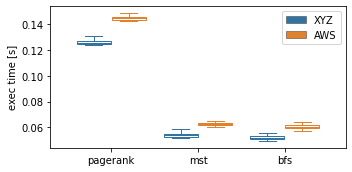

In [6]:
plt.rcParams["figure.figsize"] = (5, 2.5)
ax = sns.boxplot(data=exec_time_2048_200, y='value', x='func', hue='system', showfliers=False, linewidth=1,
                 order=['pagerank', 'mst', 'bfs'], hue_order=['XYZ', 'AWS'])
legend = ax.legend()
for i,artist in enumerate(ax.artists):
    col = artist.get_facecolor()
    artist.set_edgecolor(col)
    artist.set_facecolor('white')
    for line in ax.lines[5*i:i*5+5]:
        line.set_color(col)
        line.set_mfc(col)
        line.set_mec(col)
ax.plot()
ax.set(ylabel='exec time [s]', xlabel='')
save_fig('aws_prometheus_cmp.pdf')